In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor

In [2]:
torch.__version__

'2.5.1+cu124'

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
trainData = datasets.CIFAR10(
    root="data",
    train = True,
    download=True,
    transform = ToTensor(),
    target_transform=None
    
)

Files already downloaded and verified


In [5]:
testData = datasets.CIFAR10(
    root='data',
    train = False,
    download=True,
    transform = ToTensor()
)

Files already downloaded and verified


In [6]:
batchSize = 32

trainDataLoader = torch.utils.data.DataLoader(trainData, batch_size=batchSize, shuffle=True)
testDataLoader = torch.utils.data.DataLoader(testData, batch_size=batchSize, shuffle=False)

In [7]:
print(trainData.classes)
len(trainData.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


10

In [8]:
class CIFAR10_CNN(nn.Module):
    def __init__(self, inputShape, hiddenUnits, outputShape, batch_size):
        super().__init__()

        self.convBlock1 = nn.Sequential(
            nn.Conv2d(in_channels=inputShape, out_channels=hiddenUnits, padding=1, stride=1, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU()
        )

        self.convBlock2 = nn.Sequential(
            nn.Conv2d(in_channels=hiddenUnits, out_channels=hiddenUnits, padding = 1, stride=1, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU()
        )

        self.convBlock3 = nn.Sequential(
            nn.Conv2d(in_channels=hiddenUnits, out_channels=hiddenUnits*2, padding=1, stride=1, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU()
        )
        
        self.flattened_size = self.getConvOutput((inputShape, 32, 32))

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=self.flattened_size, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=outputShape)
        )

    def getConvOutput(self, shape):
        with torch.no_grad():
            dummy_input = torch.zeros(1, *shape)
            dummy_output = self.convBlock2(self.convBlock1(dummy_input))
            return dummy_output.numel()

    def forward(self, x):
        return self.classifier(self.convBlock2(self.convBlock1(x)))

In [9]:
model = CIFAR10_CNN(
    inputShape= 3,
    hiddenUnits = 32,
    outputShape = len(trainData.classes),
    batch_size = batchSize
).to(device)

lossFn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [10]:
def trainStep(
    model: torch.nn.Module,
    dataLoader = torch.utils.data.DataLoader,
    lossFunction = torch.nn.Module,
    optimizer = torch.optim.Optimizer):

    trainLoss = 0

    for batch, (X,y) in enumerate(dataLoader):
        X,y = X.to(device), y.to(device)
        
        y_pred = model(X)

        loss = lossFunction(y_pred, y)
        trainLoss += loss

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

    trainLoss /= len(dataLoader)
    print(f"Train loss: {trainLoss}%")
    return float(trainLoss)

In [11]:
def testStep(
    model: torch.nn.Module,
    dataLoader: torch.utils.data.DataLoader,
    lossFunction: torch.nn.Module
):
    model.eval()
    testLoss, testAcc = 0, 0

    with torch.no_grad():
        for X, y in dataLoader:
            X, y = X.to(device), y.to(device)

            y_pred = model(X)

            loss = lossFunction(y_pred, y)
            testLoss += loss.item()

            y_pred_class = torch.argmax(y_pred, dim=1)
            testAcc += (y_pred_class == y).sum().item() / len(y)

    testLoss /= len(dataLoader)
    testAcc /= len(dataLoader)
    print(f"Test loss: {testLoss:.4f} | Test accuracy: {testAcc:.4f}")
    return float(testLoss)

C:\Users\litwi\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Epoch: 0
Train loss: 1.4381211996078491%


 10%|████████▎                                                                          | 1/10 [00:28<04:17, 28.56s/it]

Test loss: 1.1399 | Test accuracy: 0.5940
Epoch: 1
Train loss: 1.056789755821228%


 20%|████████████████▌                                                                  | 2/10 [00:54<03:36, 27.04s/it]

Test loss: 0.9764 | Test accuracy: 0.6586
Epoch: 2
Train loss: 0.8835650682449341%


 30%|████████████████████████▉                                                          | 3/10 [01:40<04:08, 35.54s/it]

Test loss: 0.9046 | Test accuracy: 0.6774
Epoch: 3
Train loss: 0.7484627366065979%


 40%|█████████████████████████████████▏                                                 | 4/10 [02:46<04:45, 47.64s/it]

Test loss: 0.9057 | Test accuracy: 0.6852
Epoch: 4
Train loss: 0.6299564838409424%


 50%|█████████████████████████████████████████▌                                         | 5/10 [03:57<04:41, 56.24s/it]

Test loss: 0.8534 | Test accuracy: 0.7099
Epoch: 5
Train loss: 0.5246638059616089%


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [05:05<03:59, 59.96s/it]

Test loss: 0.9230 | Test accuracy: 0.6949
Epoch: 6
Train loss: 0.4220751225948334%


 70%|██████████████████████████████████████████████████████████                         | 7/10 [06:01<02:56, 58.92s/it]

Test loss: 0.9756 | Test accuracy: 0.7039
Epoch: 7
Train loss: 0.33292099833488464%


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [07:08<02:02, 61.28s/it]

Test loss: 1.0439 | Test accuracy: 0.7086
Epoch: 8
Train loss: 0.25265267491340637%


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [07:57<00:57, 57.52s/it]

Test loss: 1.1965 | Test accuracy: 0.7030
Epoch: 9
Train loss: 0.2009681910276413%


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [08:24<00:00, 50.42s/it]

Test loss: 1.3014 | Test accuracy: 0.6960


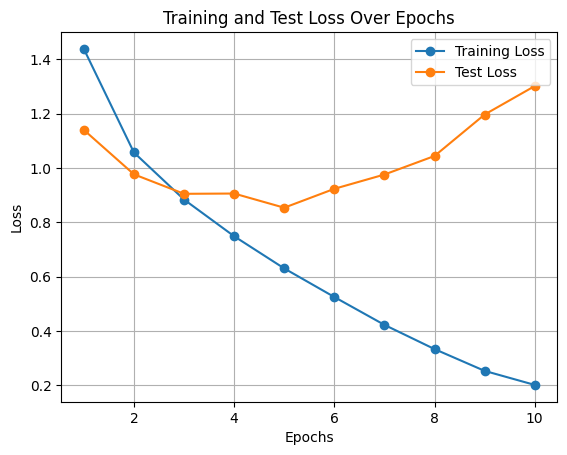

In [12]:
from tqdm.auto import tqdm

epochs = 10

trainLosses, testLosses = [], []

for epoch in tqdm(range(epochs)):
    
    print(f'Epoch: {epoch}')
    trainLoss = trainStep(model=model, dataLoader=trainDataLoader, lossFunction=lossFn, optimizer=optimizer)
    testLoss = testStep(model=model, dataLoader=testDataLoader, lossFunction=lossFn)

    trainLosses.append(trainLoss)
    testLosses.append(testLoss)


epochs = range(1, len(trainLosses) + 1)

plt.plot(epochs, trainLosses, label='Training Loss', marker='o')
plt.plot(epochs, testLosses, label='Test Loss', marker='o')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
def showSamplePredictions(model, dataLoader, num_samples):
    model.eval()
    samples_shown = 0

    plt.figure(figsize=(25, 25))

    with torch.no_grad():
        for inputs, labels in dataLoader:
            inputs, labels = inputs.to(device), labels.to(device)
            predictions = model(inputs).argmax(dim=1)

            for i in range(len(inputs)):
                if samples_shown >= num_samples:
                    plt.show()
                    return
                
                plt.subplot(10, 5, samples_shown + 1)
                plt.imshow(inputs[i].cpu().permute(1, 2, 0).numpy())
                plt.title(f'Pred: {trainData.classes[predictions[i].item()]} | Actual: {trainData.classes[labels[i].item()]}')
                plt.axis('off')
                samples_shown += 1

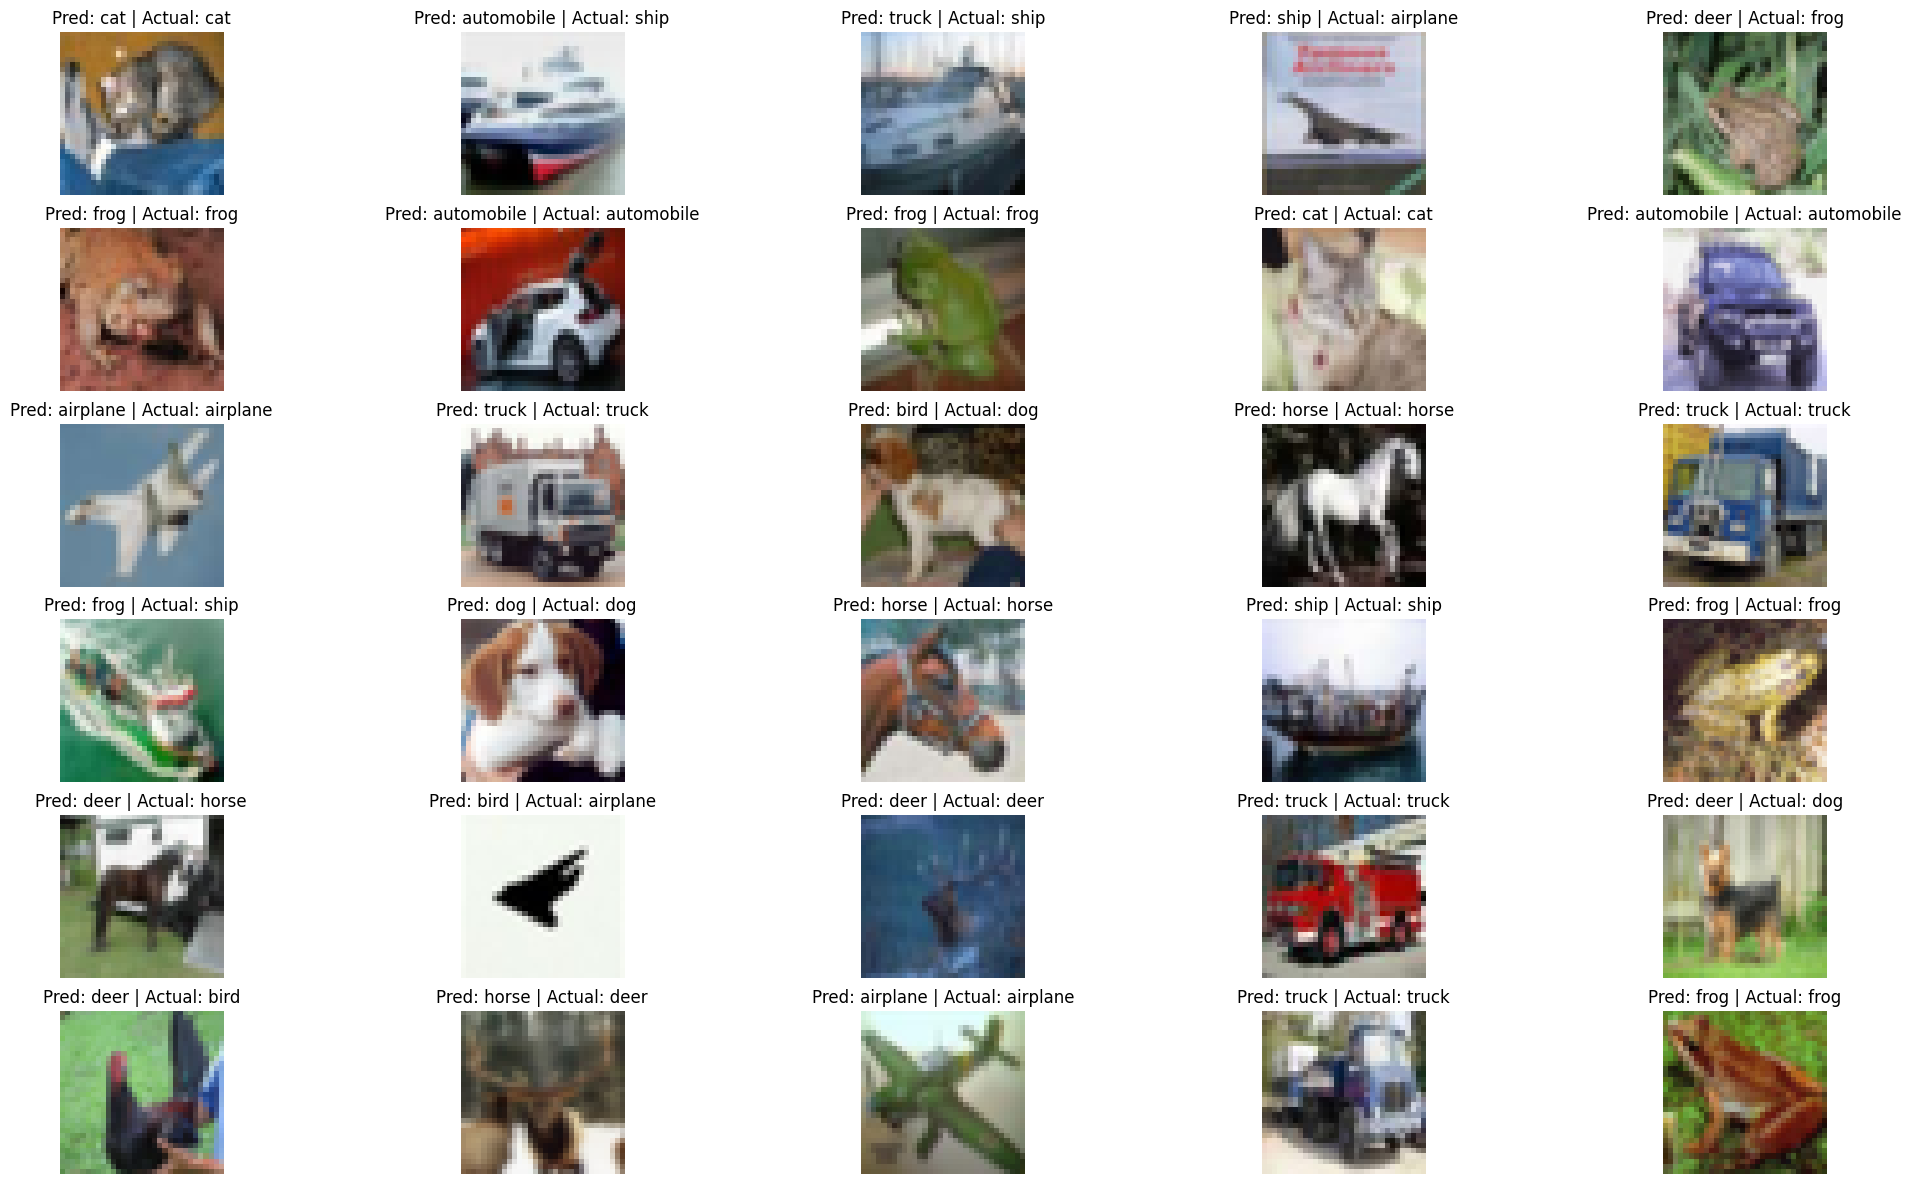

In [14]:
showSamplePredictions(model, testDataLoader, 30)

Our model does a little bit of overfitting to the test data

In [15]:
class CIFAR10_CNN(nn.Module):
    def __init__(self, inputShape, hiddenUnits, outputShape, batch_size):
        super().__init__()

        self.convBlock1 = nn.Sequential(
            nn.Conv2d(in_channels=inputShape, out_channels=hiddenUnits, padding=1, stride=1, kernel_size=3),
            nn.BatchNorm2d(hiddenUnits),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Dropout(0.25)
        )

        self.convBlock2 = nn.Sequential(
            nn.Conv2d(in_channels=hiddenUnits, out_channels=hiddenUnits, padding = 1, stride=1, kernel_size=3),
            nn.BatchNorm2d(hiddenUnits),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Dropout(0.25)
        )

        self.convBlock3 = nn.Sequential(
            nn.Conv2d(in_channels=hiddenUnits, out_channels=hiddenUnits*2, padding=1, stride=1, kernel_size=3),
            nn.BatchNorm2d(hiddenUnits),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Dropout(0.25)
        )
        
        self.flattened_size = self.getConvOutput((inputShape, 32, 32))

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=self.flattened_size, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=outputShape)
        )

    def getConvOutput(self, shape):
        with torch.no_grad():
            dummy_input = torch.zeros(1, *shape)
            dummy_output = self.convBlock2(self.convBlock1(dummy_input))
            return dummy_output.numel()

    def forward(self, x):
        return self.classifier(self.convBlock2(self.convBlock1(x)))

In [16]:
model = CIFAR10_CNN(
    inputShape= 3,
    hiddenUnits = 32,
    outputShape = len(trainData.classes),
    batch_size = batchSize
).to(device)

lossFn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Epoch: 0
Train loss: 1.3541054725646973%


 10%|████████▎                                                                          | 1/10 [00:28<04:15, 28.43s/it]

Test loss: 1.2348 | Test accuracy: 0.5637
Epoch: 1
Train loss: 0.9918484687805176%


 20%|████████████████▌                                                                  | 2/10 [01:00<04:06, 30.76s/it]

Test loss: 0.9339 | Test accuracy: 0.6704
Epoch: 2
Train loss: 0.8255872130393982%


 30%|████████████████████████▉                                                          | 3/10 [01:27<03:21, 28.85s/it]

Test loss: 0.8634 | Test accuracy: 0.6948
Epoch: 3
Train loss: 0.702892005443573%


 40%|█████████████████████████████████▏                                                 | 4/10 [01:54<02:48, 28.00s/it]

Test loss: 0.8642 | Test accuracy: 0.7033
Epoch: 4
Train loss: 0.6023606657981873%


 50%|█████████████████████████████████████████▌                                         | 5/10 [02:28<02:31, 30.30s/it]

Test loss: 0.8596 | Test accuracy: 0.7144
Epoch: 5
Train loss: 0.5134271383285522%


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [02:59<02:01, 30.45s/it]

Test loss: 0.9191 | Test accuracy: 0.7065
Epoch: 6
Train loss: 0.4345690608024597%


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [03:41<02:27, 36.99s/it]

Test loss: 0.9484 | Test accuracy: 0.7172
---Ending Early---


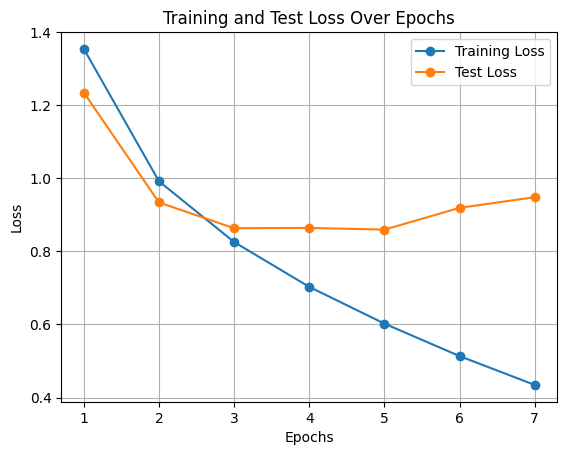

In [17]:
from tqdm.auto import tqdm

epochs = 10

trainLosses, testLosses = [], []

triggerTimes = 0
patience = 3

bestTestLoss = float('inf')

for epoch in tqdm(range(epochs)):
    
    print(f'Epoch: {epoch}')
    trainLoss = trainStep(model=model, dataLoader=trainDataLoader, lossFunction=lossFn, optimizer=optimizer)
    testLoss = testStep(model=model, dataLoader=testDataLoader, lossFunction=lossFn)
    
    trainLosses.append(trainLoss)
    testLosses.append(testLoss)
    
    if testLoss < bestTestLoss:
        bestTestLoss = testLoss
        trigger_times = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        triggerTimes += 1
        if triggerTimes >= patience:
            print(f'---Ending Early---')
            break

epochs = range(1, len(trainLosses) + 1)

plt.plot(epochs, trainLosses, label='Training Loss', marker='o')
plt.plot(epochs, testLosses, label='Test Loss', marker='o')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

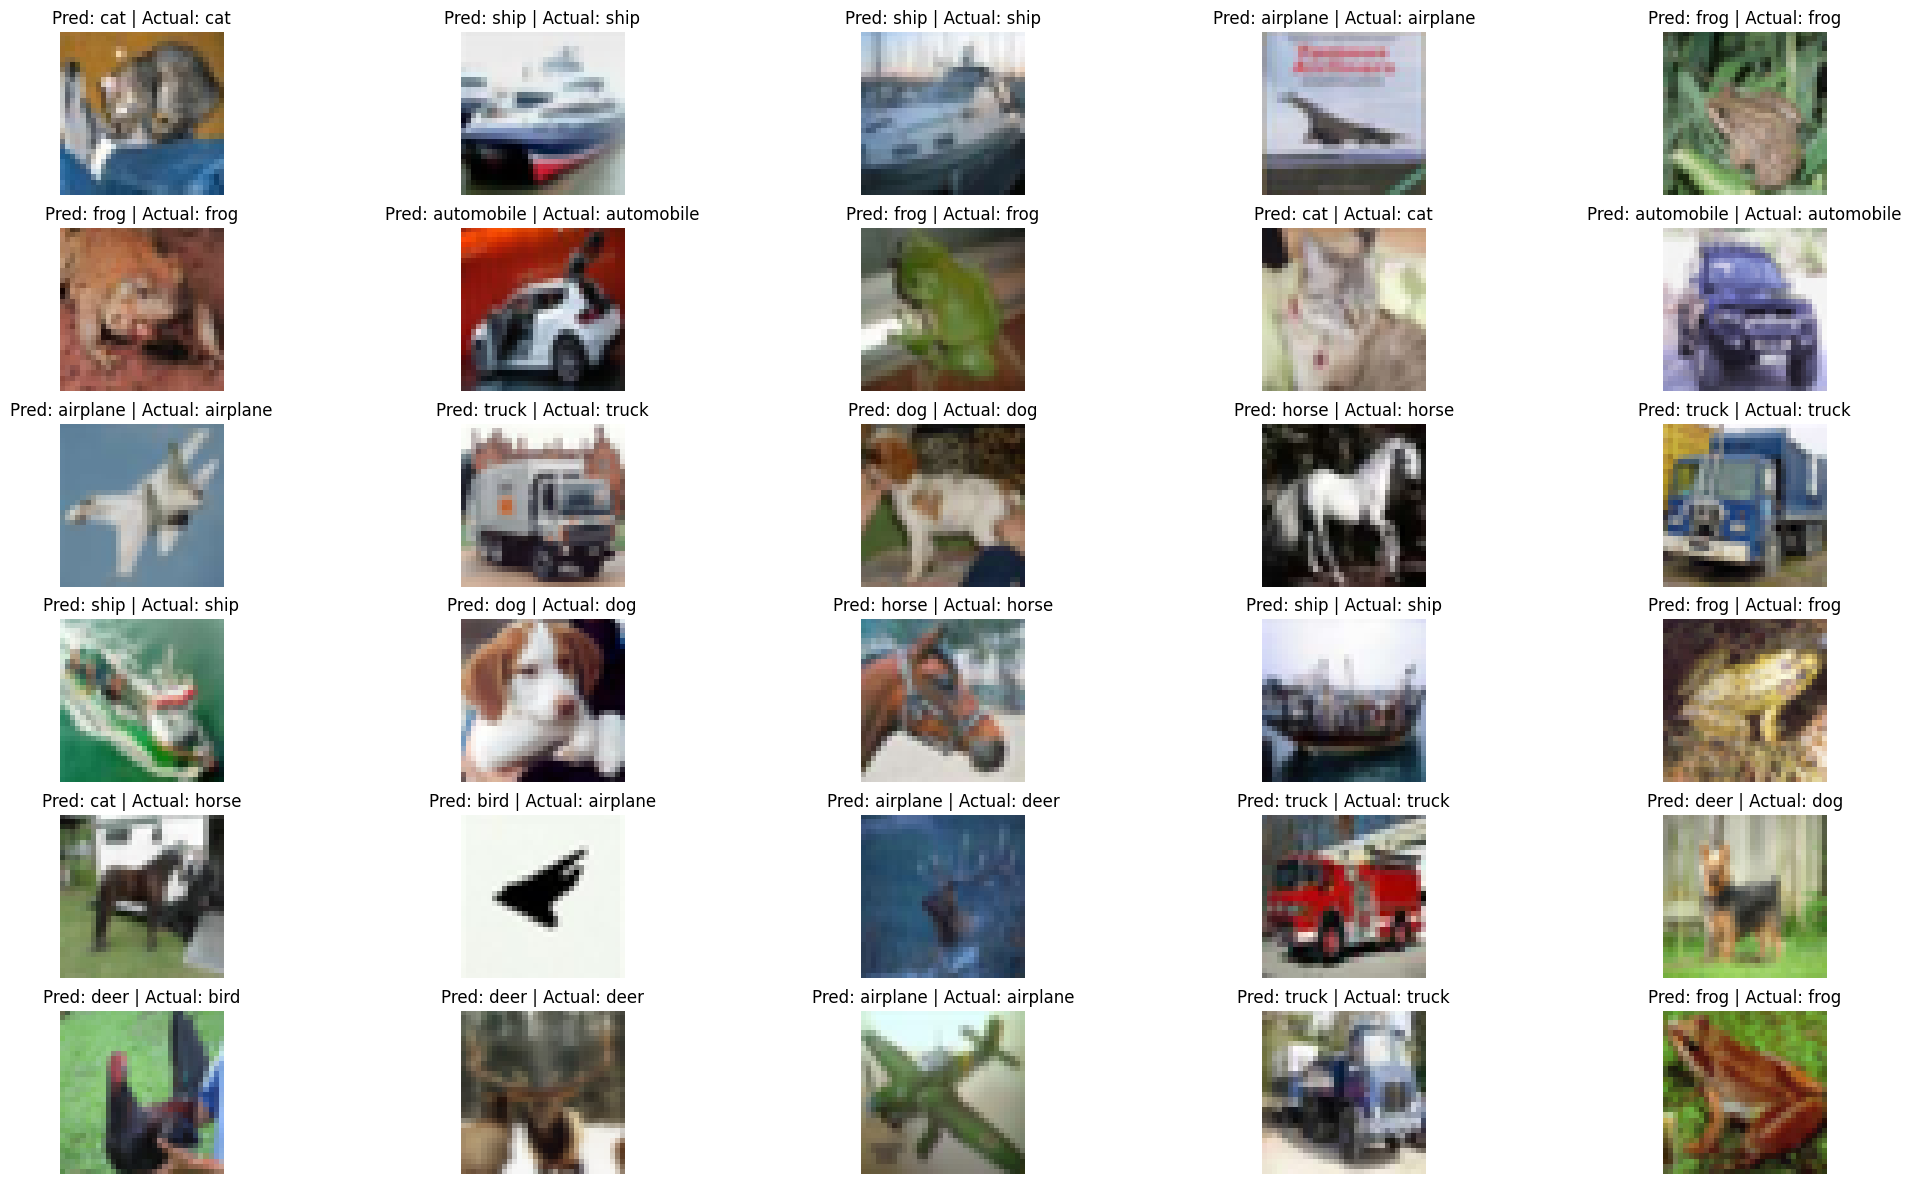

In [18]:
showSamplePredictions(model, testDataLoader, 30)

In both cases the model in 5th epoch looks to be the best choice